First install all the necessary libraries

In [1]:
#!pip install Levenshtein
#!pip install pandas
#!pip install nltk
#!pip install Levenshtein
#!pip install textblob
#!pip install scikit-learn
#!pip install xgboost

In [2]:
#imports

import pickle
import numpy as np
from textblob import TextBlob
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
import sklearn.neighbors
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import re
import os
import nltk
import Levenshtein
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

Download the NLTK data.

In [3]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

In [4]:
def read_file(file_path):
    
    with open(file_path, 'r') as file:
        text = file.read()
    return text

Choose the number of artists in the database.

In [5]:
#DEFINE A MAX NUMBER OF ARTISTS
NUMBER_OF_ARTISTS = 220

Now get the data. Note that for each artist folder, in the Songs subfolder, there are 2 files per song : the lyrics, and the RID (Regressive Imagery Dictionary) features.

In [6]:
#Get the data

path_to_songs = os.path.join(os.getcwd(), "Raw_Songs_DataBase")

artists = os.listdir(path_to_songs)
artists_all = [art for art in artists if art[0] != "."]
artists = random.sample(artists_all, NUMBER_OF_ARTISTS) #select the correct number of artists
artists = sorted(artists)

# Specify the file path to save the artist list
artist_list_file = "artist_list.pkl"

# Save the 'artists' list to a file using pickle
with open(artist_list_file, 'wb') as file:
    pickle.dump(artists, file)

x = []
RID_features = []
y = []

songs_per_artist={art : 0 for art in artists}

titles = []

for art in artists: 
    

    path_to_artist = os.path.join(path_to_songs, art)
    path_to_artist_songs = os.path.join(path_to_artist, "Songs")
    
    songs = os.listdir(path_to_artist_songs)
    for song in songs:
        if song[0] != ".":
            if song[-3:] != "RID":
                path = os.path.join(path_to_artist_songs, song)
                titles.append(song)
                lyrics =  read_file(path)
                x.append(lyrics)
                songs_per_artist[art] += 1
                y.append(art)
            else: #is a RID file
                path = os.path.join(path_to_artist_songs, song)
                text =  read_file(path)
                RID_features.append(text)

    
arts_dict = {}
for i in range(len(artists)):
    arts_dict[artists[i]] = i
    
arts_dict_op = {i: artist for artist, i in arts_dict.items()}
    
for i in range(len(y)):
    art = y[i]
    y[i] = int(arts_dict[art])

x = np.array(x)
y = np.array(y) 
titles = np.array(titles)

assert len(x) == len(RID_features)

In [7]:
#Set the directory in which to save the plots
save_dir = os.path.join(os.getcwd(), "saved_plots")

Now let us see what our dataset looks like.

Number of songs : 24829
Number of artists : 220
Average number of songs per artist : 112
Maximum number of songs: 201
Minimum number of songs: 2


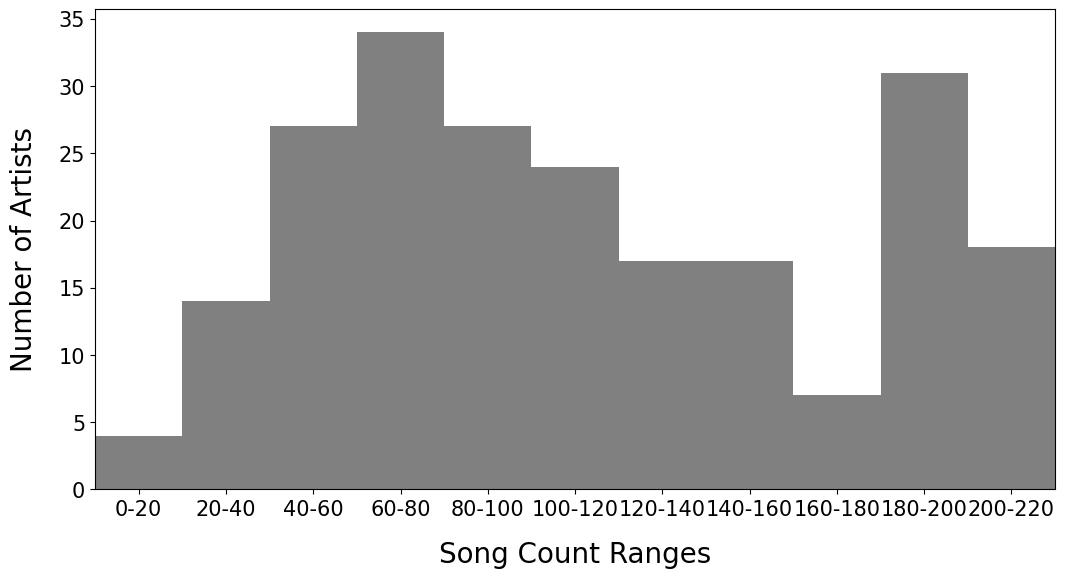

In [8]:
print(f'Number of songs : {len(x)}')
print(f'Number of artists : {len(artists)}')
print(f'Average number of songs per artist : {int(len(x)/len(artists))}')

max_value = max(songs_per_artist.values())
min_value = min(songs_per_artist.values())

print(f"Maximum number of songs: {max_value}")
print(f"Minimum number of songs: {min_value}")

# Define the bins for different song count ranges
max_bin = ((max_value // 20) + 1) * 20
bins = [i*20 for i in range((max_bin//20) + 1)]

# Initialize counts for each bin
bin_counts = [0] * (len(bins) - 1)

# Count the number of artists falling into each bin
for value in songs_per_artist.values():
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            bin_counts[i] += 1
            break

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

bar_lefts = range(len(bin_counts))
bar_heights = bin_counts

plt.bar(bar_lefts, bar_heights, width=1.0, facecolor='gray')

plt.xlabel('Song Count Ranges', fontsize=20, labelpad=15)
plt.ylabel('Number of Artists', fontsize=20, labelpad=15)

plt.xticks(range(len(bin_counts)), [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)], fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(-0.5, len(bin_counts) - 0.5)

save_path = os.path.join(save_dir, f'distribution_songs_start.png')
plt.savefig(save_path, bbox_inches='tight')

plt.show()

We start processing our data.

In [9]:
#remove all that is into paranthesis in the titles
for i in range(len(titles)):
    titles[i] = re.sub(r'\([^()]+\)', '', titles[i]).strip()

In [10]:
def flatten(text):
    text = [word for sentence in text for word in sentence]
    return text

In [11]:
def pre_processing(text):
    
    text = text.lower() #lowercase
    
    #split in lines
    text = text.split("\n") 
    
    #remove useless punctuation
    punctuation = r'[/()-.?!,";{}]'
    text= [re.sub(punctuation,"", sentence) for sentence in text]
    
    #seperate each word
    text = [line.split(' ') for line in text]
    
    #flatten the list of lists

    
    #remove empty lines
    text = [line for line in text if len(line)!=0]
    
    
    #remove all expressions in between brackets and empty words
    text = [ [word.strip() for word in line if len(word) != 0 and word[0]!= "["] for line in text]
    
    #remobe empty lines again
    text = [line for line in text if len(line)!=0]
    nb_lines = len(text)
    
    #stemmatization
    ps = PorterStemmer()
    text = [[ps.stem(word) for word in line] for line in text]
    
    nb_words = 0
    for line in text:
        nb_words += len(line)


    return text, nb_lines, nb_words

def title_pre_processing(title):
    title = title.lower()  # lowercase
    #title = re.sub(r'\.txt$', '', title)  # remove .txt extension
    punctuation = r'[-.?!,";/]'
    title = re.sub(punctuation, "", title)
    title = re.sub(r'[\(\[].*?[\)\]]', '', title)
    title = title.strip()
    return title

In [12]:
data = []
for i in range(len(x)):
    song = x[i]
    point = list(pre_processing(song))
    point.append(song)
    t = title_pre_processing(titles[i])
    point.append(t)
    point.append(y[i])
    data.append(point)
    

In [13]:
df = pd.DataFrame(data, columns=['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist'])
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0
4,"[[babi], [you, can, do, magic], [babi], [isn't...",15,49,\nBaby\nYou can do magic\nBaby\nIsn't it tragi...,baby,0


We write functions to plot features in a box plot and a bar plot.

In [14]:
def plot_box_graph(features, save=None):
    
    nb_graphs = len(features)
    if nb_graphs == 1:
        feature = features[0]
        to_plot = []
        for art in sample:
            d1 = df.loc[df['Artist'] == art, feature]
            to_plot.append(d1.tolist())
        plt.boxplot(to_plot)
        xtick_labels = [arts_dict_op[i] for i in sample]
        plt.gca().set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
        plt.title(feature)
        if save != None:
            save_path = os.path.join(save_dir, f'plot_{features}.png')
            plt.savefig(save_path, bbox_inches='tight')

        plt.show()
    else:
        fig, graphs = plt.subplots(1, nb_graphs, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
    
        plots = [[] for _ in range(nb_graphs)]

        for art in sample:
            for i in range(len(features)):
                feature = features[i]
                d = df.loc[df['Artist'] == art, feature]
                plots[i].append(d)
        
        for i in range(len(plots)):
            graphs[i].boxplot(plots[i])

        xtick_labels = [arts_dict_op[i] for i in sample]
        
        for i in range(len(features)):
            feature = features[i]
            graphs[i].set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
            graphs[i].set_title(feature)

        if save != None:
            save_path = os.path.join(save_dir, f'plot_{features}.png')
            plt.savefig(save_path, bbox_inches='tight')

        
        plt.show()
        
def plot_bar_graph(feature, save = None):

    to_plot = []
    for art in sample:
        d1 = df.loc[df['Artist'] == art, feature]
        to_plot.append(d1.mean())

   
    plt.bar(np.arange(len(to_plot)), to_plot, color='gray')
    xtick_labels = [arts_dict_op[i] for i in sample]
    plt.xticks(np.arange(len(to_plot)), xtick_labels, rotation='vertical', fontsize=8)
    plt.title(feature)
    
    if save != None:
        save_path = os.path.join(save_dir, f'plot_{feature}.png')
        plt.savefig(save_path)

    plt.show()

Now we parse the RID features and add them to the dataframe.

In [15]:
#let's add the RID columns
def RID_dict(text):
    text = text.split("\n")
    text = [re.findall(r'\d+(?:\.\d+)?|\D+', t) for t in text]
    #text = [t.split(' ') for t in text if len(t)!=0 and t[0].isupper()]
    text = [[word.strip() for word in t if re.match(r'^[A-Z0-9.]', word)] for t in text]
    text = [arr for arr in text if len(arr) != 0]
    summary = text[-4:-1]
    details = text[:-4]
    lenght = text[-1][0]
    details = [ [word.replace(' ', ':') for word in line] for line in details]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]

    details = {d[0] : (int(d[1]))/(int(lenght)) for d in details}
    #details = {d[0] : int(d[1]) for d in details}
    summary = {d[0] : float(d[1]) for d in summary}
    
    return details, summary

RID_DETAILS = {}
RID_SUMMARY = {'RID_PRIMARY': [], 'RID_SECONDARY' : [], 'RID_EMOTIONS' : []}

#first let's get the labels
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in d.keys():
        if key not in RID_DETAILS.keys():
            RID_DETAILS['RID_'+key] = []

#now fill in the values
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in RID_DETAILS.keys():
        if key[4:] in d.keys():
            RID_DETAILS[key].append(d[key[4:]])
        else:
            RID_DETAILS[key].append(0)
    for key in s.keys():
        RID_SUMMARY['RID_'+key].append(s[key])


In [16]:
df = df.assign(**RID_DETAILS)
df = df.assign(**RID_SUMMARY)
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,...,RID_PRIMARY:NEED:ORALITY,RID_PRIMARY:SENSATION:HARD,RID_PRIMARY:ICARIAN:IMAGERY:DESCENT,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:CHAOS,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:RANDOM:MOVEMENT,RID_PRIMARY:REGRESSIVE:COGNITION:TIMELESSNESS,RID_PRIMARY:SENSATION:ODOR,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0,0.066176,0.040441,0.036765,0.033088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.766234,49.350649,16.883117
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0,0.032877,0.005479,0.024658,0.008219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.240506,51.898734,8.860759
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0,0.040816,0.005102,0.015306,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.222222,51.111111,6.666667
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0,0.015528,0.000000,0.012422,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.813559,47.457627,23.728814
4,"[[babi], [you, can, do, magic], [babi], [isn't...",15,49,\nBaby\nYou can do magic\nBaby\nIsn't it tragi...,baby,0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.500000,50.000000,37.500000


Add a new feature and remove the empty songs.

In [17]:
df = df[df["Nb_Words"] != 0]
df["Nb_Words_Per_Line"] = df["Nb_Words"]/df["Nb_Lines"]

Clean the dataset.

In [18]:
s1 = df.shape[0]
df = df.drop_duplicates(subset=['Title', 'Artist'])
s2 = df.shape[0]
print(f'Dropped {s1 - s2} duplicates')

raw_songs = df["Raw_Lyrics"].to_list()

Dropped 341 duplicates


In [19]:
df = df[df['Nb_Words'] >= 50]
s3 = df.shape[0]

print(f'Dropped {s2 - s3} songs that were too short')

df = df[~df['Title'].str.contains('intro', case=False)]
df = df[~df['Title'].str.contains('outro', case=False)]
s4 = df.shape[0]

print(f'Dropped {s3 - s4} intros and outros')

Dropped 497 songs that were too short
Dropped 25 intros and outros


In [20]:
def dropping_artists():
    
    artist_counts = df['Artist'].value_counts()

    # remove all artists that have less than 80 songs
    artists_to_drop = artist_counts[artist_counts < 80].index

    # Create a boolean mask indicating rows to be dropped
    mask = df['Artist'].isin(artists_to_drop)

    # Filter and drop the corresponding rows from the DataFrame
    df.drop(df[mask].index, inplace=True)

    l1 = len(artists)
    # Remove the artists from the artists array
    new_artists = [art for art in artists if arts_dict[art] not in artists_to_drop]
    dropped_artists = [art for art in artists if arts_dict[art] in artists_to_drop]
    for art in dropped_artists:
        del arts_dict_op[arts_dict[art]]
        del arts_dict[art]

    l2 = len(new_artists)


    s5 = df.shape[0]
    print(f'Dropped {l1 - l2} artists that had too few songs : -{s4 - s5} songs')
    
dropping_artists()

Dropped 82 artists that had too few songs : -4129 songs


In [21]:
#FUNCTIONS TO MEASURE SIMILARITY

def levenshtein_similarity(text1, text2):
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    similarity = (max_length - distance) / (max_length + 1)
    return similarity

def jaccard_similarity(text1, text2):
    set1 = set(text1)
    set2 = set(text2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / (union + 1)
    return similarity

We remove covers.

In [22]:
mask = np.zeros(len(df), dtype=bool)

for idx1, row1 in df.iterrows():
    song1 = row1["Raw_Lyrics"]
    title1 = row1["Title"]
    artist1 = row1["Artist"]
    
    # keep same title but different artist
    duplicate_rows = df[(df["Title"] == title1) & (df["Artist"] != artist1)]
    
    # calculate similarity scores between two songs with the same title
    similarity_scores_lev = duplicate_rows["Raw_Lyrics"].apply(lambda x: levenshtein_similarity(song1, x))
    
    # get rows with similarity scores above 0.8
    similar_rows_lev = duplicate_rows[similarity_scores_lev > 0.8]

    df.drop(similar_rows_lev.index, inplace=True)

s3 = df.shape[0]
print(f'Dropped {s2 - s3} covers')

Dropped 5167 covers


In [23]:
#OPTIONAL : we can also choose to undersample artists that are too represented

def undersampling():
    # Identify artists with a total number of songs greater than 130
    artists_above_threshold = artist_counts[artist_counts > 130].index

   
    for artist in artists_above_threshold:
        # Get the indices of songs by the current artist
        artist_indices = df[df['Artist'] == artist].index

        # Calculate the number of songs to be dropped
        songs_to_drop = len(artist_indices) - 130

        # Randomly select and drop songs until count reaches 130
        songs_to_keep = np.random.choice(artist_indices, size=130, replace=False)
        df.drop(artist_indices.difference(songs_to_keep), inplace=True)

    s7 = df.shape[0]
    print(f'Dropped {s6 - s7} songs from undersampling too represented artists')

Let us see the final dataset.

In [24]:
artist_counts = df['Artist'].value_counts()

artist_most_songs = artist_counts.idxmax()
most_songs_count = artist_counts.max()

artist_least_songs = artist_counts.idxmin()
least_songs_count = artist_counts.min()

print(f"Artist with the most songs: {artists[artist_most_songs]} ({most_songs_count} songs)")
print(f"Artist with the least songs: {artists[artist_least_songs]} ({least_songs_count} songs)")

Artist with the most songs: Reba McEntire (198 songs)
Artist with the least songs: Chet Baker (78 songs)


In [25]:
print("AFTER CLEANING\n")

print(f'Number of songs : {df.shape[0]}')
print(f'Number of artists : {len(arts_dict)}')
print(f'Average number of songs per artist : {int((df.shape[0])/len(arts_dict))}')

AFTER CLEANING

Number of songs : 19315
Number of artists : 138
Average number of songs per artist : 139


Let us check the most important RID features.

In [26]:
df_rid = df.filter(regex=r'^RID')

pca = PCA(n_components=len(df_rid.columns))

pca.fit(df_rid)

# get the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# sort the variance ratios in descending order
sorted_variance_ratio = sorted(explained_variance_ratio, reverse=True)

# Get the indices of the top 10 features with the most variance
top_10_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Keep only the top 10 features in the DataFrame
df_top_10 = df_rid.iloc[:, top_10_indices]
print('Top 10 RID features:')
for rid in df_top_10.columns:
    print(rid)

Top 10 RID features:
RID_SECONDARY:INSTRUMENTAL:BEHAVIOR
RID_EMOTIONS:EXPRESSIVE:BEHAVIOR
RID_SECONDARY:TEMPORAL:REFERENCES
RID_PRIMARY:SENSATION:SOUND
RID_SECONDARY:SOCIAL:BEHAVIOR
RID_PRIMARY:SENSATION:VISION
RID_PRIMARY:SENSATION:SOFT
RID_SECONDARY:ABSTRACTION
RID_PRIMARY:SENSATION:TOUCH
RID_EMOTIONS:AFFECTION


We add a new feature: Type-Token ratio. It shows how repetitive a song is.

In [27]:
songs = df["Lyrics"].to_list()
songs_flatten = [[word for line in song for word in line] for song in songs]
nb_words = df["Nb_Words"].to_list()

#unique word means appears only once in the song
TTR = []
for song, l in zip(songs_flatten, nb_words):
    if l == 0:
        print(song)
    dic = {word: 0 for word in song}
    non_unique_words = set()
    for word in song:
        dic[word] += 1
        if dic[word] > 1: #if it appeared more than once, add it
            non_unique_words.add(word)
    nb_unique_words = l - len(non_unique_words)
    ttr = nb_unique_words / l
    TTR.append(ttr)
    
df['TTR'] = TTR

For visualisation purposes, we will only plot the data for 10 random artists.

In [28]:
if NUMBER_OF_ARTISTS > 10:
    sample = random.sample(list(arts_dict_op.keys()), 10)
else:
    sample = random.sample(list(arts_dict_op.keys()), NUMBER_OF_ARTISTS)

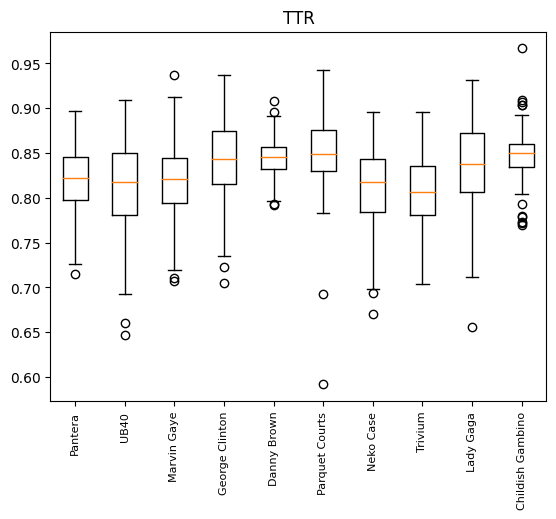

In [29]:
plot_box_graph(["TTR"], save = False)

Add the lines similarity.

In [30]:
raw_songs = df["Raw_Lyrics"].to_list()
nb_lines = df["Nb_Lines"].to_list()

lines_similarity_jacc = []

examples = []

for song, num_lines in zip(songs, nb_lines):
    line_similarity_count_jacc = 0
    
    for line1, line2 in itertools.combinations(song, 2):
        similarity_jacc = jaccard_similarity(line1, line2)
        
        
        if  similarity_jacc > 0.5:  # adjust the threshold as needed
            line_similarity_count_jacc += 1
            examples.append([line1, line2])
    
    lines_similarity_jacc.append(line_similarity_count_jacc)
    

df["Lines_similarity"] = lines_similarity_jacc

We look at some examples of what two similar lines can be.

In [31]:
reduced_examples = random.choices(examples, k=5)
for ex in reduced_examples:
    for l in ex:
        print(l)
    print("\n")

['get', 'down', 'on', 'it', 'get', 'down', 'on', 'it']
['get', 'down', 'on', 'it']


['say', 'i', "can't", 'breath', 'i', "can't", 'breath', 'with', 'thi', "muhfuckin'", 'flag', 'round', 'my', 'neck', 'yeah', 'i', "can't", 'breath']
['say', 'i', "can't", 'breath', 'i', "can't", 'i', "can't", 'breath', 'with', 'thi', "muhfuckin'", 'flag', 'round', 'my', 'neck']


['and', 'i', "don't", 'know', 'whi']
['and', 'i', "don't", 'know', 'whi']


['how', 'long', 'can', 'i', 'keep', 'it', 'up']
['how', 'long', 'can', 'i', 'keep', 'it', 'up']


['see', 'the', 'problem', 'is', 'the', 'heart', 'is', 'mine']
['the', 'heart', 'is', 'mine']




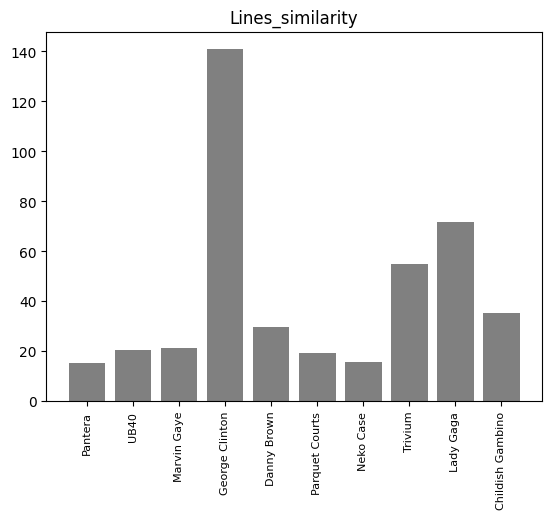

In [32]:
plot_bar_graph("Lines_similarity")

We add the POS (Part Of Speech) tags and the part of speech tags.

In [33]:
supertags_dict = {
    'VB': 'V', 'VBD': 'V', 'VBG': 'V', 'VBN': 'V', 'VBP': 'V', 'VBZ': 'V', #verbs
    'NN': 'N', 'NNS': 'N', 'NNP': 'N', 'NNPS': 'N', #nouns
    'RB': 'ADV', 'RBR': 'ADV', 'RBS': 'ADV', 'WRB': 'ADV', #adverbs
    'JJ': 'ADJ', 'JJR': 'ADJ', 'JJS': 'ADJ', #adjectives
    'DT': 'DET', 'PDT': 'DET', 'WDT': 'DET', #determinents
    'PRP': 'PRON', 'PRP$': 'PRON', 'WP': 'PRON', 'WP$': 'PRON'} #pronouns

supertags = ['N', 'V', 'ADV', 'ADJ', 'DET', 'PRON']
chunk_tags = ['GPE', 'PERSON', 'ORGANIZATION', 'LOCATION', 'FACILITY', 'GSP']

#'GPE': 'Geopolitical Entity: Refers to countries, cities, states, or regions.',
#'PERSON': 'Person: Refers to individuals or groups of people.',
#'ORGANIZATION': 'Organization: Refers to named entities representing companies, institutions, or groups.',
#'LOCATION': 'Location: Refers to specific places or locations.',
#'FACILITY': 'Facility: Refers to buildings, structures, or other physical facilities.',
#'GSP': 'General Single Purpose: Refers to a general chunk tag with a single-purpose label.'

def split_sentences(text):

    text = re.sub(r'\([^()]*\)', ' ', text)
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('  ', ' ')
    sentences = re.split(r'(?:[.!?])|\n\n', text)
    sentences = [s.strip() for s in sentences if len(s)!=0]
    return sentences

In [34]:
def pos_chunk(text):
    # tokenize into sentences and words
    sentences = split_sentences(text)
    words = [nltk.word_tokenize(sent) for sent in sentences]
    
    # POS tagging
    pos_tags = [nltk.pos_tag(sent) for sent in words]
    
    # chunking
    chunked_sentences = [nltk.ne_chunk(pos_tag_sent) for pos_tag_sent in pos_tags]

    # calculate POS tag distribution
    pos_tag_distribution = {suptag: 0 for suptag in supertags}
    for sent in pos_tags:
        pos_tag_distribution.update({supertags_dict[tag]: pos_tag_distribution.get(supertags_dict[tag], 0) + 1
                                     for _, tag in sent if tag in supertags_dict})

    # calculate chunk tag distribution
    chunk_tag_distribution = {chunk_tag: 0 for chunk_tag in chunk_tags}
    for sent in chunked_sentences:
        chunk_tag_distribution.update({chunk.label(): chunk_tag_distribution.get(chunk.label(), 0) + 1
                                       for chunk in sent if hasattr(chunk, 'label') and chunk.label() in chunk_tags})

    return pos_tag_distribution, chunk_tag_distribution


In [35]:
raw_songs = df["Raw_Lyrics"].to_list()
#df = df.drop("Raw_Lyrics", axis = 1)
nb_words = df["Nb_Words"].to_list()

POS = {'POS_'+key : [] for key in supertags}

CHUNK = {'CHUNK_'+key : [] for key in chunk_tags}

for raw, l in zip(raw_songs, nb_words):
    pos, chunk = pos_chunk(raw)
    for key in pos.keys():
        POS['POS_'+key].append(pos[key] / l)
        
    for key in chunk.keys():
        CHUNK['CHUNK_'+key].append(chunk[key] / l)

In [36]:
df = df.assign(**POS)
df = df.assign(**CHUNK)
df.columns

Index(['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist',
       'RID_SECONDARY:INSTRUMENTAL:BEHAVIOR',
       'RID_EMOTIONS:EXPRESSIVE:BEHAVIOR', 'RID_SECONDARY:TEMPORAL:REFERENCES',
       'RID_PRIMARY:SENSATION:SOUND', 'RID_SECONDARY:SOCIAL:BEHAVIOR',
       'RID_PRIMARY:SENSATION:VISION', 'RID_PRIMARY:SENSATION:SOFT',
       'RID_SECONDARY:ABSTRACTION', 'RID_PRIMARY:SENSATION:TOUCH',
       'RID_EMOTIONS:AFFECTION',
       'RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:PASSIVITY',
       'RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM',
       'RID_PRIMARY:ICARIAN:IMAGERY:HEIGHT',
       'RID_PRIMARY:ICARIAN:IMAGERY:ASCENT',
       'RID_PRIMARY:REGRESSIVE:COGNITION:CONCRETENESS',
       'RID_PRIMARY:REGRESSIVE:COGNITION:CONSCIOUSNESS:ALTERATION',
       'RID_PRIMARY:ICARIAN:IMAGERY:DEPTH', 'RID_SECONDARY:MORAL:IMPERATIVE',
       'RID_SECONDARY:RESTRAINT', 'RID_EMOTIONS:SADNESS',
       'RID_PRIMARY:ICARIAN:IMAGERY:WATER', 'RID_PRIMARY:SENSATION:COLD',
       'RID_EMOTIONS:AGGRE

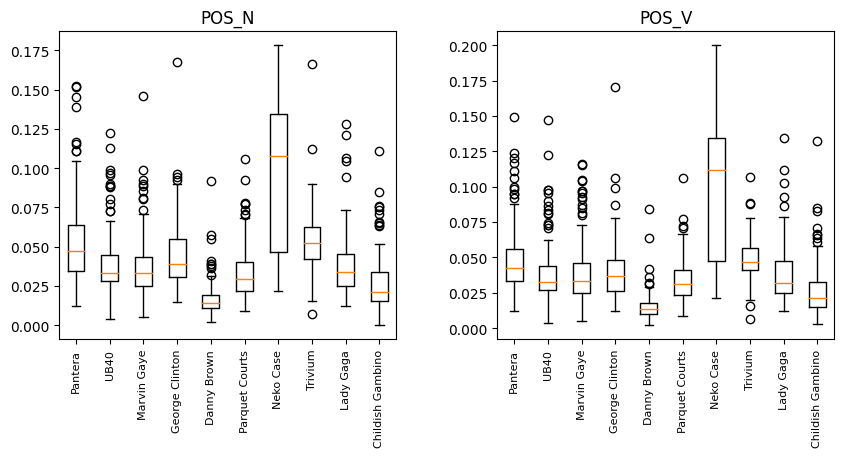

In [37]:
plot_box_graph(["POS_N", "POS_V"])

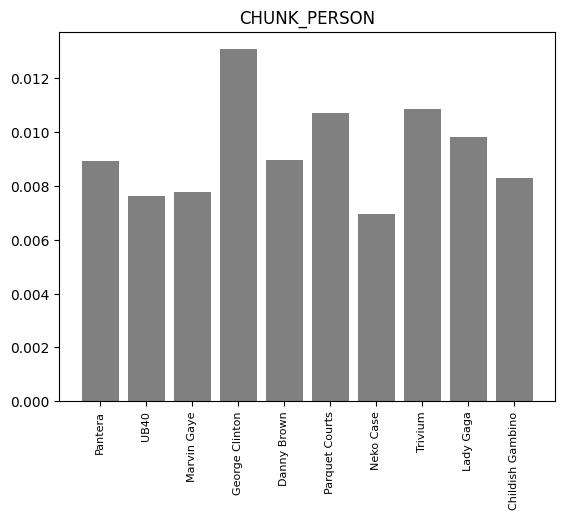

In [38]:
plot_bar_graph("CHUNK_PERSON")

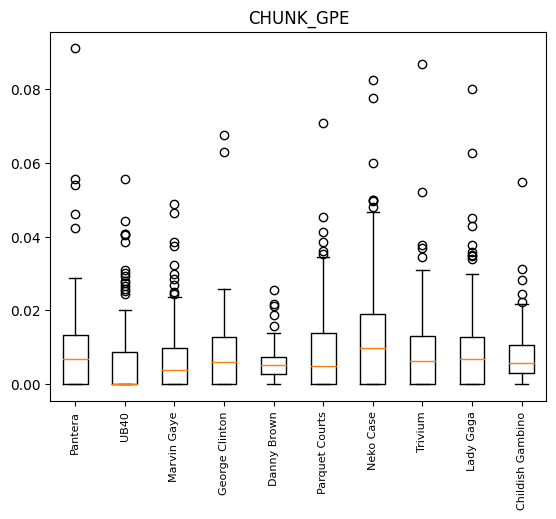

In [39]:
plot_box_graph(["CHUNK_GPE"])

We analyze the vocabulary of the songs : rare words and slang words.

In [40]:
path_to_dicts = os.path.join(os.getcwd(), "Dictionaries")

path = os.path.join(path_to_dicts, "rare-filtered.txt")
rare = read_file(path)
rare = rare.split("\n")
rare = rare[:-1]

path = os.path.join(path_to_dicts, "slang-filtered.txt")
slang = read_file(path)
slang = slang.split("\n")
slang = slang[:-1]

slang = set(slang)
rare = set(rare)

rare_use = []
slang_use = []

songs_flatten = [flatten(song) for song in songs] 
                 
for song in songs_flatten:
    
    count_r = 0
    count_s = 0
    l = len(song)
    for w in song:
        if w in slang:
            count_s += 1
        if w in rare:
            count_r +=1
    slang_use.append(count_s/l)
    rare_use.append(count_r/l)
    

df['Slang'] = slang_use
df['Rare'] = rare_use

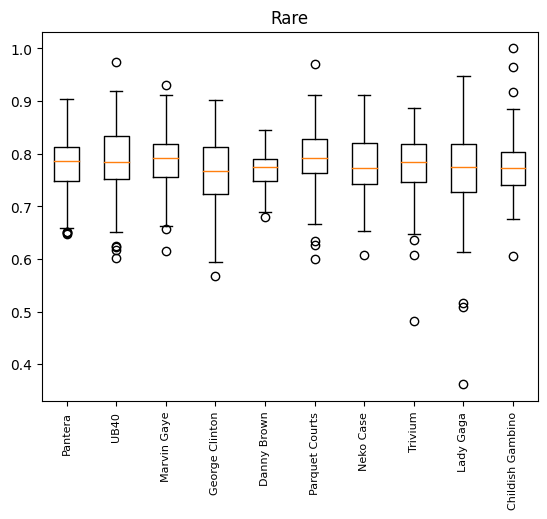

In [41]:
plot_box_graph(["Rare"])

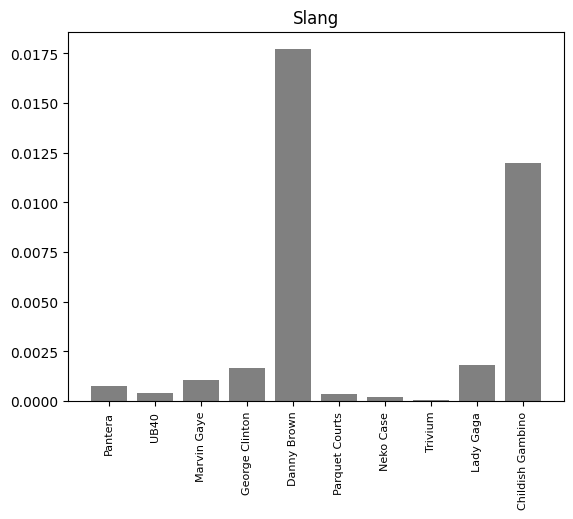

In [42]:
plot_bar_graph("Slang")

Now we check whether or not the title appears in the song.

In [43]:
ttls = df["Title"].to_list()

title_in_song = []

raw_songs = [s.lower() for s in raw_songs]


for song, title, art in zip(raw_songs, ttls, df["Artist"].to_list()):
    pattern = re.escape(title)  # Escape special characters in the title
    if re.search(pattern, song):
        flag = True
    else:
        flag = False
    title_in_song.append(flag)


df['Title_In_Song'] = title_in_song
                

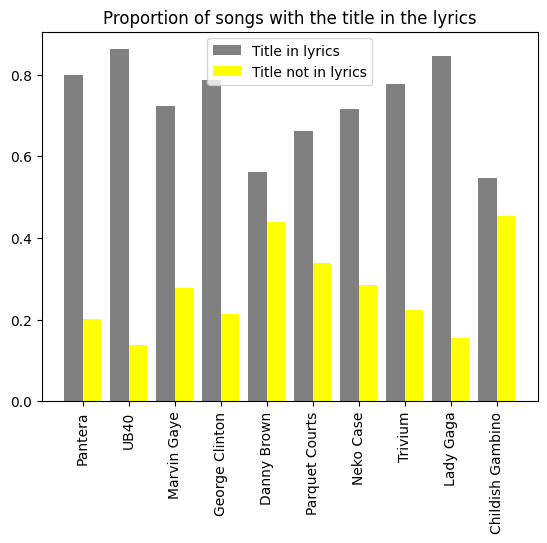

In [44]:
t_in = []
t_not_in = []
total_songs = []

for art in sample:
    songs_by_artist = df.loc[df['Artist'] == art, 'Title_In_Song'].tolist()
    tr = songs_by_artist.count(True)
    fa = songs_by_artist.count(False)
    total_songs.append(len(songs_by_artist))
    t_in.append(tr)
    t_not_in.append(fa)

xtick_labels = [arts_dict_op[i] for i in sample]

X_axis = np.arange(len(xtick_labels))

t_in = np.array(t_in)
t_not_in = np.array(t_not_in)
total_songs = np.array(total_songs)


plt.bar(X_axis - 0.2, t_in/total_songs, 0.4, label='Title in lyrics', color = "gray")
plt.bar(X_axis + 0.2, t_not_in/total_songs, 0.4, label='Title not in lyrics', color="yellow")

plt.xticks(X_axis, xtick_labels, rotation='vertical')
plt.title('Proportion of songs with the title in the lyrics')
plt.legend()
plt.show()
    

We add the subjectivity and polarity of the lyrics. 

In [45]:
sub = []
pol = []
for song in raw_songs:
    scores = TextBlob(song)
    pol.append(scores.sentiment.polarity)
    sub.append(scores.sentiment.subjectivity)
    
df["Polarity"] = pol
df["Subjectivity"] = sub

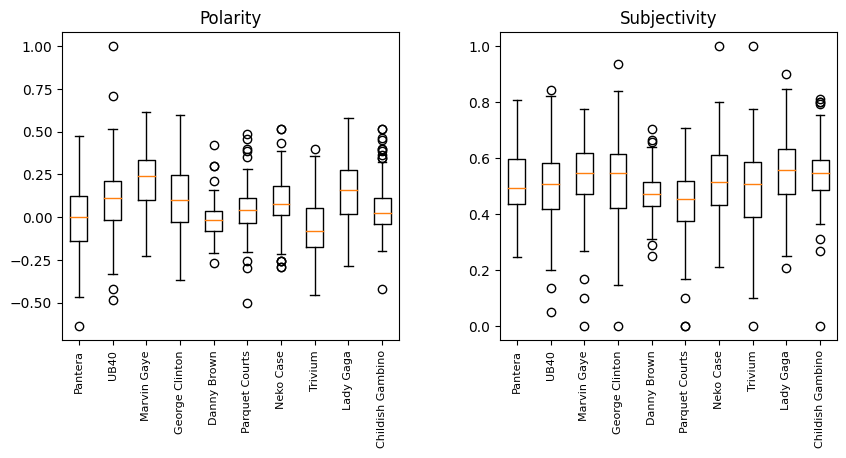

In [46]:
plot_box_graph(["Polarity", "Subjectivity"])

Now we want to add the TFIDF features. For this, we need to split our dataset into train and test, so we can compose documents with only the training points.

In [47]:
df = df.reset_index(drop=True)

artists = df['Artist'].unique()

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['Artist'])

print(f'Training size : {train_df.shape[0]}')
print(f'Testing size : {test_df.shape[0]}')

Training size : 16417
Testing size : 2898


In [48]:
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,...,CHUNK_PERSON,CHUNK_ORGANIZATION,CHUNK_LOCATION,CHUNK_FACILITY,CHUNK_GSP,Slang,Rare,Title_In_Song,Polarity,Subjectivity
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0,0.066176,0.040441,0.036765,0.033088,...,0.023077,0.0,0.0,0.0,0.0,0.0,0.819231,False,0.202222,0.543611
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0,0.032877,0.005479,0.024658,0.008219,...,0.003195,0.0,0.0,0.0,0.0,0.0,0.722045,True,-0.006344,0.417491
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0,0.040816,0.005102,0.015306,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.752632,False,0.084301,0.579630
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0,0.015528,0.000000,0.012422,0.000000,...,0.006410,0.0,0.0,0.0,0.0,0.0,0.878205,True,0.300881,0.539837
4,"[[make, somebodi, happi, is, a, question, of, ...",34,200,\nMaking somebody happy is a question of give ...,bangaboomerang,0,0.011673,0.000000,0.019455,0.143969,...,0.010000,0.0,0.0,0.0,0.0,0.0,0.775000,False,0.355000,0.614375


We compose the documents. One document has all the lyrics of 1 single artist.

In [49]:
documents = []
available_artists  = list(set(df['Artist'].to_list()))
for i in available_artists:
    d = train_df.loc[train_df['Artist'] == i, 'Lyrics'].tolist()
    d = [flatten(song) for song in d]
    d = flatten(d)
    documents.append(d)
    
    
documents = [' '.join(doc) for doc in documents]

df_docs_train = pd.DataFrame({"All_Lyrics" : documents, 
                        "Artist" : available_artists})

df_docs_train.head()

,All_Lyrics,Artist
0,if i ever write my ode to freedom it will be i...,0
1,look at the morn sun shine so brightli love is...,2
2,when i wa just a littl boy i threw away all of...,4
3,the red light mean you'r leav the white one' m...,5
4,dark thought rise up deep in your mind the kil...,6


Get the TFIDF weights.

In [50]:
docs = df_docs_train["All_Lyrics"].to_list()

cv = CountVectorizer()
stem_count_vector = cv.fit_transform(docs)
#stem_count_vector = cv.fit_transform(documents)

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit_transform(stem_count_vector)

# Get the feature names and IDF weights
feature_names = cv.get_feature_names_out()
idf_weights = tfidf_transformer.idf_

df_words_weights = pd.DataFrame({'word': cv.get_feature_names_out(), 'weight': tfidf_transformer.idf_})
 
df_words_weights.sort_values('weight').head()

,word,weight
10858,eye,1.0
17116,know,1.0
34319,who,1.0
30943,than,1.0
21847,old,1.0


In [51]:
df_words_weights.sort_values('weight', ascending=False).head()

,word,weight
17773,leval,5.241327
25447,relist,5.241327
13249,gradnama,5.241327
13248,gradi,5.241327
25450,reloadin,5.241327


In [52]:
df_words_weights.shape[0]

35546

In [53]:
df.shape[0]

19315

In [54]:
def tdif_features(songs):
    
    song_features_list = []

    for i, song in enumerate(songs):

        # convert the song to a string
        song_text = ' '.join(song)

        # transform the song text to a count vector
        song_counts = cv.transform([song_text])

        # compute the TF-IDF features for the song
        song_features = tfidf_transformer.transform(song_counts)

        # convert the sparse matrix to a dataframe
        song_features_df = pd.DataFrame(song_features.toarray(), columns=feature_names)

        # append the song features to the list
        song_features_list.append(song_features_df)

    song_features_list = np.array(song_features_list)
    song_features_list = song_features_list.reshape((song_features_list.shape[0], song_features_list.shape[2]))
    df_tfidf = pd.DataFrame(song_features_list, columns=feature_names)
    df_tfidf['Artist'] = df['Artist'].to_list()
    
    return df_tfidf

In [55]:
df_tfidf = tdif_features(songs_flatten)

In [56]:
df_tfidf.shape

(19315, 35547)

In [57]:
valid_columns = df_tfidf.iloc[:, :-1].select_dtypes(include=np.number)
# calculate the sum of each row
sum_array = np.array(valid_columns.sum(axis=1))

# add the sum_array as a new column in the DataFrame
df["TF_IDF_Score"] = sum_array

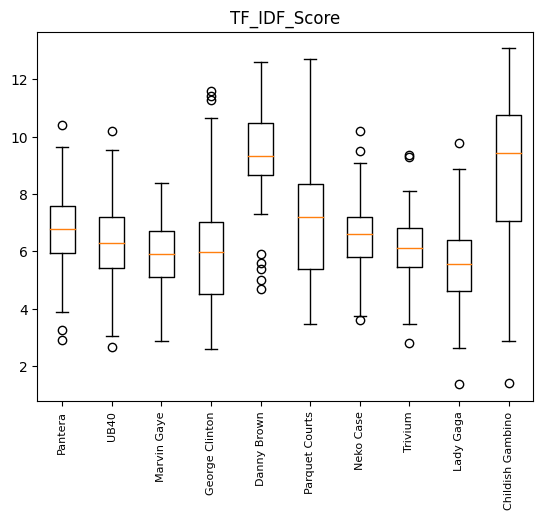

In [58]:
plot_box_graph(["TF_IDF_Score"])

Let us only keep the 1000 terms with the most weight.

In [59]:
to_keep = df_words_weights.iloc[:1000]["word"].tolist()

We have now a data frame where the features are the selected 1000 terms and each row is a song

In [60]:
df_tfidf_reduced = pd.concat([df_tfidf[column] for column in to_keep], axis=1)

# Display the new DataFrame
df_tfidf_reduced.head()

,00,000,0001,007,01,010,012,02,03,04,...,agn,agnost,agnu,ago,agogo,agoin,agon,agoni,agonis,agonna
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We reduce the number of TFIDF features using a PCA.

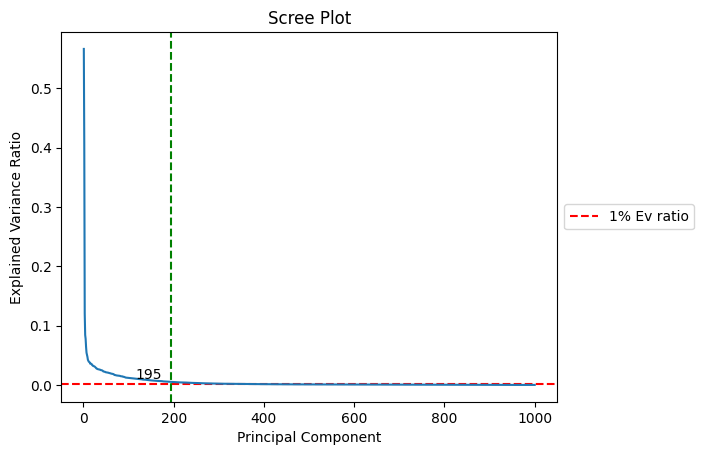

In [61]:
# Perform PCA
pca = PCA()
pca.fit(df_tfidf_reduced)
df_transformed = pca.transform(df_tfidf_reduced)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.axhline(y=0.001, color='r', linestyle='--', label='1% Ev ratio')

# Create scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio*5, marker='', linestyle='-')

# Find the index of intersection
intersection_index = -1
for i in range(len(explained_variance_ratio)):
    if explained_variance_ratio[i] <= 0.001:
        intersection_index = i
        break

# Add a vertical line at the intersection point
plt.axvline(x=intersection_index + 1, color='g', linestyle='--')
plt.text(intersection_index - 50, 0.01, f'{intersection_index + 1}', ha='center')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.show()

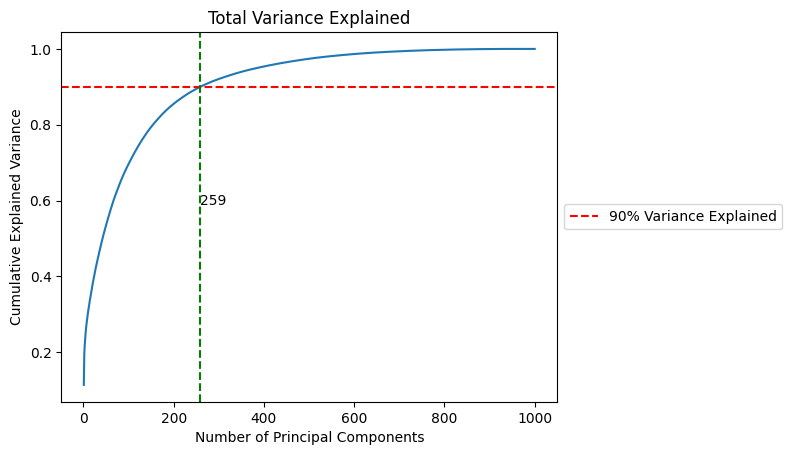

In [62]:
# Calculate cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
# Create total variance explained plot with a line
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Total Variance Explained')
# Add a line at 80% cumulative explained variance
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Explained')
plt.legend()
# Find the index where cumulative variance exceeds 90%
idx = next(x for x, value in enumerate(cumulative_variance) if value >= 0.9)
# Add a vertical line at the intersection point
plt.axvline(x=idx + 1, color='g', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.text(idx + 1, 0.6, f'{idx + 1}', ha='left', va='center')

plt.show()

We keep the 150 principal components.

In [63]:
n_comp = 150
pca = PCA(n_components=n_comp)
df_tfidf_pca = pca.fit_transform(df_tfidf_reduced)

df_filtered_pca = pd.DataFrame(df_tfidf_pca, columns=[f'PC{i}' for i in range(1, n_comp+1)])

df_filtered_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150
0,0.026503,-0.007639,-0.002156,-0.000371,-0.000500,-0.001568,-0.001154,-0.000507,-0.000338,-0.001353,...,-0.000013,0.000025,-0.000077,-0.000041,0.000002,-0.000087,3.144856e-05,-0.000041,0.000035,-0.000078
1,-0.008100,0.001732,-0.002219,-0.000370,-0.000510,-0.001645,-0.000444,-0.000523,-0.000372,-0.001288,...,-0.000753,0.000881,0.000414,0.000957,0.000083,-0.000224,5.720029e-04,0.000268,0.000206,-0.002260
2,-0.008150,-0.007865,-0.002112,-0.000388,-0.000478,-0.001683,-0.001055,-0.000515,-0.000407,-0.001369,...,-0.000049,0.000036,-0.000084,-0.000019,0.000013,-0.000124,9.866352e-07,-0.000051,0.000029,-0.000089
3,0.020294,-0.007680,-0.002148,-0.000374,-0.000496,-0.001588,-0.001136,-0.000508,-0.000351,-0.001356,...,-0.000020,0.000027,-0.000078,-0.000037,0.000004,-0.000094,2.599107e-05,-0.000043,0.000034,-0.000080
4,-0.008188,-0.007751,-0.002127,-0.000412,-0.000518,-0.001700,-0.001014,-0.000379,-0.000439,-0.001506,...,-0.000011,-0.000361,0.000177,0.000080,-0.000080,-0.000130,5.038488e-05,0.000284,-0.000152,0.000142


In [64]:
#############
# new data frame containing all the numerical features
############
new_df = pd.concat([df.reset_index(drop=True), df_filtered_pca.reset_index(drop=True)], axis = 1)
new_df = new_df.reset_index(drop=True)
new_df.columns

Index(['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist',
       'RID_SECONDARY:INSTRUMENTAL:BEHAVIOR',
       'RID_EMOTIONS:EXPRESSIVE:BEHAVIOR', 'RID_SECONDARY:TEMPORAL:REFERENCES',
       'RID_PRIMARY:SENSATION:SOUND',
       ...
       'PC141', 'PC142', 'PC143', 'PC144', 'PC145', 'PC146', 'PC147', 'PC148',
       'PC149', 'PC150'],
      dtype='object', length=223)

Now we only keep the numerical features.

In [65]:
numerical_df = new_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
numerical_df.head()

,Nb_Lines,Nb_Words,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_PRIMARY:SENSATION:VISION,RID_PRIMARY:SENSATION:SOFT,RID_SECONDARY:ABSTRACTION,...,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150
0,47,260,0.066176,0.040441,0.036765,0.033088,0.025735,0.018382,0.011029,0.011029,...,-0.000013,0.000025,-0.000077,-0.000041,0.000002,-0.000087,3.144856e-05,-0.000041,0.000035,-0.000078
1,49,313,0.032877,0.005479,0.024658,0.008219,0.002740,0.038356,0.000000,0.041096,...,-0.000753,0.000881,0.000414,0.000957,0.000083,-0.000224,5.720029e-04,0.000268,0.000206,-0.002260
2,28,190,0.040816,0.005102,0.015306,0.000000,0.010204,0.005102,0.000000,0.045918,...,-0.000049,0.000036,-0.000084,-0.000019,0.000013,-0.000124,9.866352e-07,-0.000051,0.000029,-0.000089
3,33,312,0.015528,0.000000,0.012422,0.000000,0.015528,0.003106,0.000000,0.043478,...,-0.000020,0.000027,-0.000078,-0.000037,0.000004,-0.000094,2.599107e-05,-0.000043,0.000034,-0.000080
4,34,200,0.011673,0.000000,0.019455,0.143969,0.007782,0.003891,0.000000,0.031128,...,-0.000011,-0.000361,0.000177,0.000080,-0.000080,-0.000130,5.038488e-05,0.000284,-0.000152,0.000142


We are gojng to visualize the data in a PCA plot, so we choose again a sample of 10 artists to plot. The line can be re-run multiple times to get a more interesting sample.

In [66]:
if NUMBER_OF_ARTISTS > 10:
    sample = random.sample(list(arts_dict_op.keys()), 10)
else:
    sample = random.sample(list(arts_dict_op.keys()), NUMBER_OF_ARTISTS)

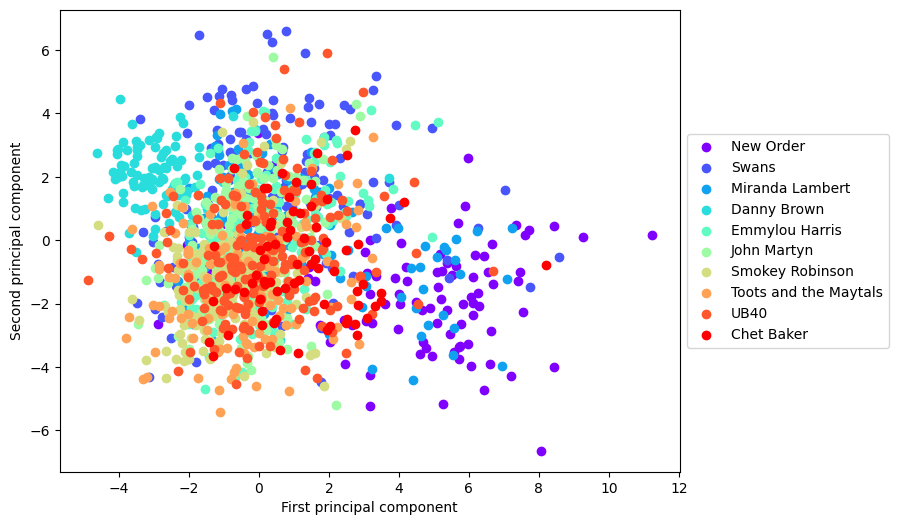

In [67]:
y = new_df["Artist"].to_list()
y = np.array([int(yy) for yy in y])


scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

artist_labels = [arts_dict_op[i] for i in sample]

# Create separate scatter plots for each unique label
colors = plt.cm.rainbow(np.linspace(0, 1, len(sample)))  # Generate a range of colors

fig, ax = plt.subplots(figsize=(8, 6))

for label, art, color in zip(sample, artist_labels, colors):
    mask = (y == label)
    scatter = ax.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=[color], label=art)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

# Save the plot as an image
#save_path = os.path.join(save_dir, 'PCA_all_feat_2.png')
#plt.savefig(save_path, bbox_inches='tight', bbox_extra_artists=[ax.legend_])

plt.show()

Now, let us plot random pairs of artists.

In [68]:
scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

combinations = list(itertools.combinations(arts_dict_op.keys(), 2))
random.shuffle(combinations)
sampled_indices = combinations[:4]
artist_labels_list = [[arts_dict_op[i] for i in indices] for indices in sampled_indices]


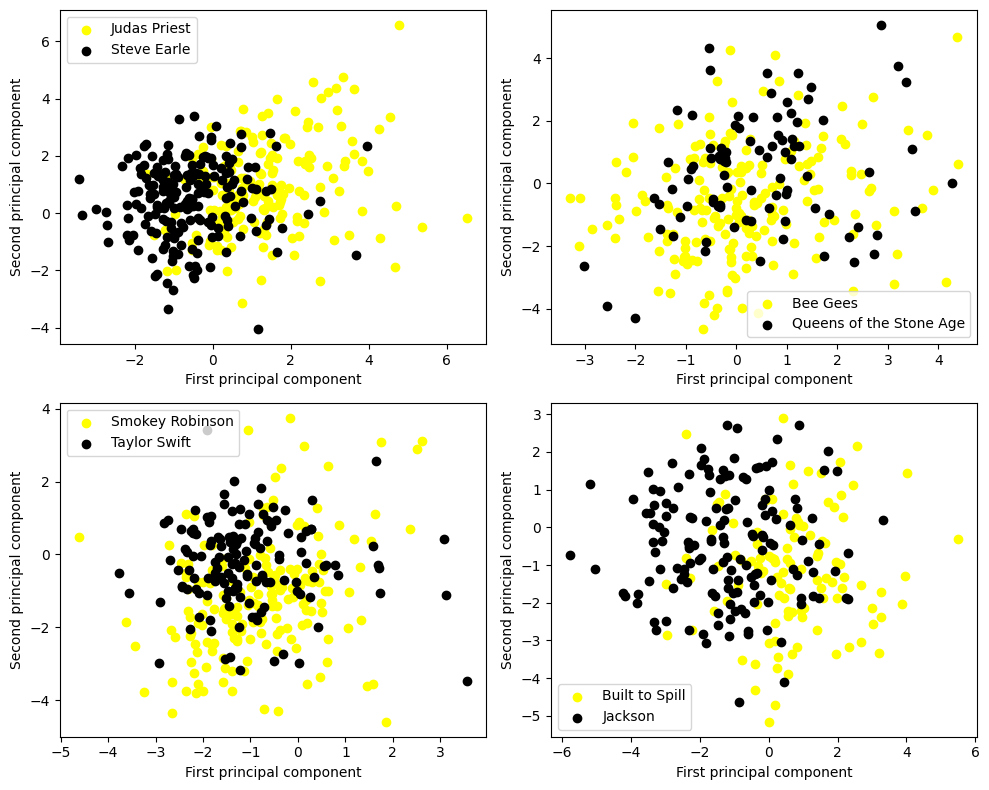

In [69]:
# yellow for artist 1 and black for artist 2
colors_list = ['yellow', 'black']

plt.figure(figsize=(10, 8))

for i, indices in enumerate(sampled_indices):
    plt.subplot(2, 2, i + 1)
    for j, label in enumerate(indices):
        mask = (y == label)
        color = colors_list[j % 2]  # alternate between yellow and black
        scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=color, label=artist_labels_list[i][j])
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend()
    #save_path = os.path.join(save_dir, f'plot_2arts_PCA2_second.png')
    #plt.savefig(save_path)

plt.tight_layout()
plt.show()

We group all the TF-IDF features as entries of a TF-IDF vector.

In [70]:
def create_tfidfvector(df):
    if 'TFIDF_Vector' in df.columns:
        df.drop('TFIDF_Vector', inplace=True, axis=1)

    pca_arrays = []
    for index, row in df.iterrows():
        pca_columns = row[df.columns.str.startswith('PC')].values
        pca_arrays.append(np.array(pca_columns))

    df['TFIDF_Vector'] = pca_arrays

create_tfidfvector(new_df)

In [74]:
train_indices = train_df.index
test_indices = test_df.index
train_df = new_df.iloc[train_indices]
test_df = new_df.iloc[test_indices]

pickle_filename = 'songs_dataset_train.pkl'
with open(pickle_filename, 'wb') as file:
    pickle.dump(train_df, file)

pickle_filename = 'songs_dataset_test.pkl'
with open(pickle_filename, 'wb') as file:
    pickle.dump(test_df, file)

# GET THE TESTING DATA

In [72]:
num_train = train_df.drop(['Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
num_test = test_df.drop(['Lyrics', 'Title', 'Raw_Lyrics'], axis=1)


In [ ]:
pickle_filename = 'num_df_scaled.pkl'
with open(pickle_filename, 'wb') as file:
    pickle.dump(numerical_df_scaled, file)